In [1]:
#load modules
print('loading modules...')
import numpy as np
import basic
import pickle
import curvedsky
#import cmb
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt

##########################################################################

import os,sys
import pylab as pl
import numpy as np
import lenspyx
import healpy as hp
sys.path.append('/sharefs/alicpt/users/chenwz/download/cmblensplus2/utils')
sys.path.append('/sharefs/alicpt/users/chenwz/Testarea/FORECAST/Foreground/foreground_run')

#from noise_making import *
from utils_mine import *

from lenspyx.utils import camb_clfile
from lenspyx.utils_hp import synalm, almxfl, alm2cl

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))    
sys.path.insert(0,camb_path)

import camb
from camb import model, initialpower ,correlations

from scipy.special import factorial

import pymaster as nm

loading modules...


/sharefs/alicpt/users/chenwz/anaconda3/envs/lens/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


loading modules...


In [10]:
dlmax = 3071
lmax = 3071
nside = 2048
q2k = lambda l: l*(l + 1) / 2 # potential -> convergence
q2d = lambda l: (l*(l + 1)) ** 0.5 # potential -> deflection
cut = np.where((np.arange(dlmax + 1) > 10) * (np.arange(dlmax + 1) < 3072), 1, 0) # band limit

def qmap2dmap(qmap,nside):
    q2d = lambda l: (l*(l + 1)) ** 0.5 # potential -> deflection
    qlm = hp.map2alm(qmap)
    dmap = hp.alm2map(hp.almxfl(qlm, q2d(np.arange(lmax + 1))),nside)
    return dmap

In [27]:
comb_alm = np.load('/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/LSS_tracer/COMB_KIL/comb_KIL_442.npy')

COMB_NOISY = hp.alm2map(hp.almxfl(comb_alm[0], cut*cli(q2k(np.arange(dlmax + 1)))),nside)

pmap_input = hp.read_map(f'/sharefs/alicpt/users/chenwz/reconstruction_2048_simons/test/ALILENS/sims/cmbs/map_P_2048_0442.fits')

In [28]:
dmap_input = qmap2dmap(pmap_input,nside)

In [29]:
dmap_rec = qmap2dmap(COMB_NOISY,nside)

In [30]:
def map_cut(nside,map,lcut,lmax=None):
    if lmax == None:
        lmax = 3*nside-1
    blm = curvedsky.utils.hp_map2alm(nside,lmax,lmax,map)
    map_cut = curvedsky.utils.hp_alm2map(nside,lcut,lcut,blm[:lcut+1,:lcut+1])
    return map_cut
llow = 20
lcut = 2000


dmap_rec_cut = map_cut(nside,dmap_rec,lcut,lmax=None) - map_cut(nside,dmap_rec,llow,lmax=None)
dmap_input_cut = map_cut(nside,dmap_input,lcut,lmax=None) - map_cut(nside,dmap_input,llow,lmax=None)

In [18]:
mask = hp.read_map(f'/sharefs/alicpt/users/chenwz/Testarea/FORECAST/mask/mask_{nside}_Sm.fits')

In [20]:
def view_map(m, title, min=None, max=None, cmap='YlGnBu_r'):
     """ View map.
     """
     # TODO beautify this plot
     rot = [180, 60, 0]


     m = hp.read_map(m, verbose=False) if isinstance(m, str) else m
     m[ m==0. ] = np.nan # in case the input map is an apodization mask

     if min==None: min = m[ ~np.isnan(m) ].min()
     if max==None: max = m[ ~np.isnan(m) ].max()

     hp.orthview(m, title=title, min=min, max=max, rot=rot, half_sky=True, cmap=cmap)
     hp.graticule()

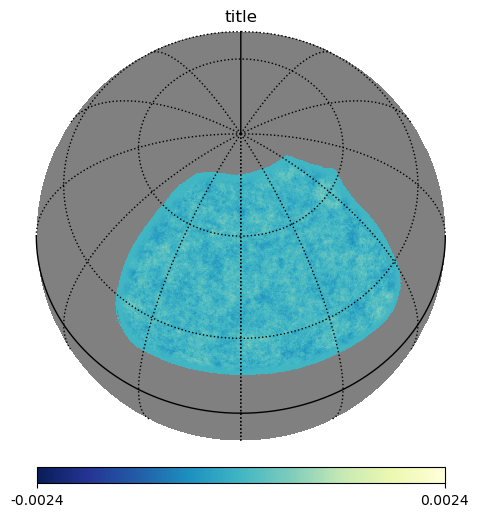

In [31]:
view_map((dmap_rec_cut-dmap_input_cut)*mask, title='title', min=-0.0024, max=0.0024,)


In [2]:
rhos0 = np.load(f"/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/LSS_tracer/rhos/rhos_0.npz")
lbin = rhos0['lbin']
rhos = rhos0['rhos_binned']
rhos_comb = rhos0['rho_comb_binned']

for i in range(1,500):
    rhosi = np.load(f"/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/LSS_tracer/rhos/rhos_{i}.npz")
    rhos += rhosi['rhos_binned']
    rhos_comb += rhosi['rho_comb_binned']
rhos /= 500
rhos_comb /= 500

In [3]:
#从WSL理论计算

rho_eff_LSST_tomo_binned = np.array([0.86286781, 0.87686931, 0.84599822, 0.84532485, 0.81835202,
       0.79999415, 0.77064421, 0.75770927, 0.76033205, 0.74753809,
       0.73292278, 0.72875511, 0.71186265, 0.7119877 , 0.70366961,
       0.69493175, 0.70559495, 0.69591462, 0.69622536, 0.68676362,
       0.69373284, 0.69264416, 0.69283868, 0.68475097, 0.68745993,
       0.69227742, 0.68716868, 0.68534971, 0.69371072, 0.69148186,
       0.6877707 , 0.69128518, 0.693636  , 0.68959669, 0.69501096,
       0.69438624, 0.6939469 , 0.7017677 , 0.69780918, 0.70419181,
       0.6992905 , 0.69922064, 0.70071276, 0.69963276, 0.70668293,
       0.70656336, 0.70311854, 0.7016738 , 0.70284333, 0.70402973])

rho_LSST_full_binned = np.array([0.80233684, 0.69920687, 0.66568945, 0.64653052, 0.62691419,
       0.61211591, 0.60496286, 0.60493733, 0.5973556 , 0.6008641 ,
       0.60152938, 0.6027706 , 0.60324102, 0.60408363, 0.60704567,
       0.61051186, 0.61433658, 0.6178147 , 0.62091552, 0.62419115,
       0.62748886, 0.6308732 , 0.63456814, 0.63837474, 0.64209141,
       0.64556855, 0.64878976, 0.65192649, 0.65509288, 0.658286  ,
       0.66147589, 0.66460775, 0.66762867, 0.67050244, 0.67324221,
       0.67589741, 0.67851209, 0.68109945, 0.68363281, 0.68608815,
       0.68845184, 0.69072648, 0.69291801, 0.69504192, 0.6971129 ,
       0.69913347, 0.70110194, 0.70300788, 0.7048457 , 0.70662007])    

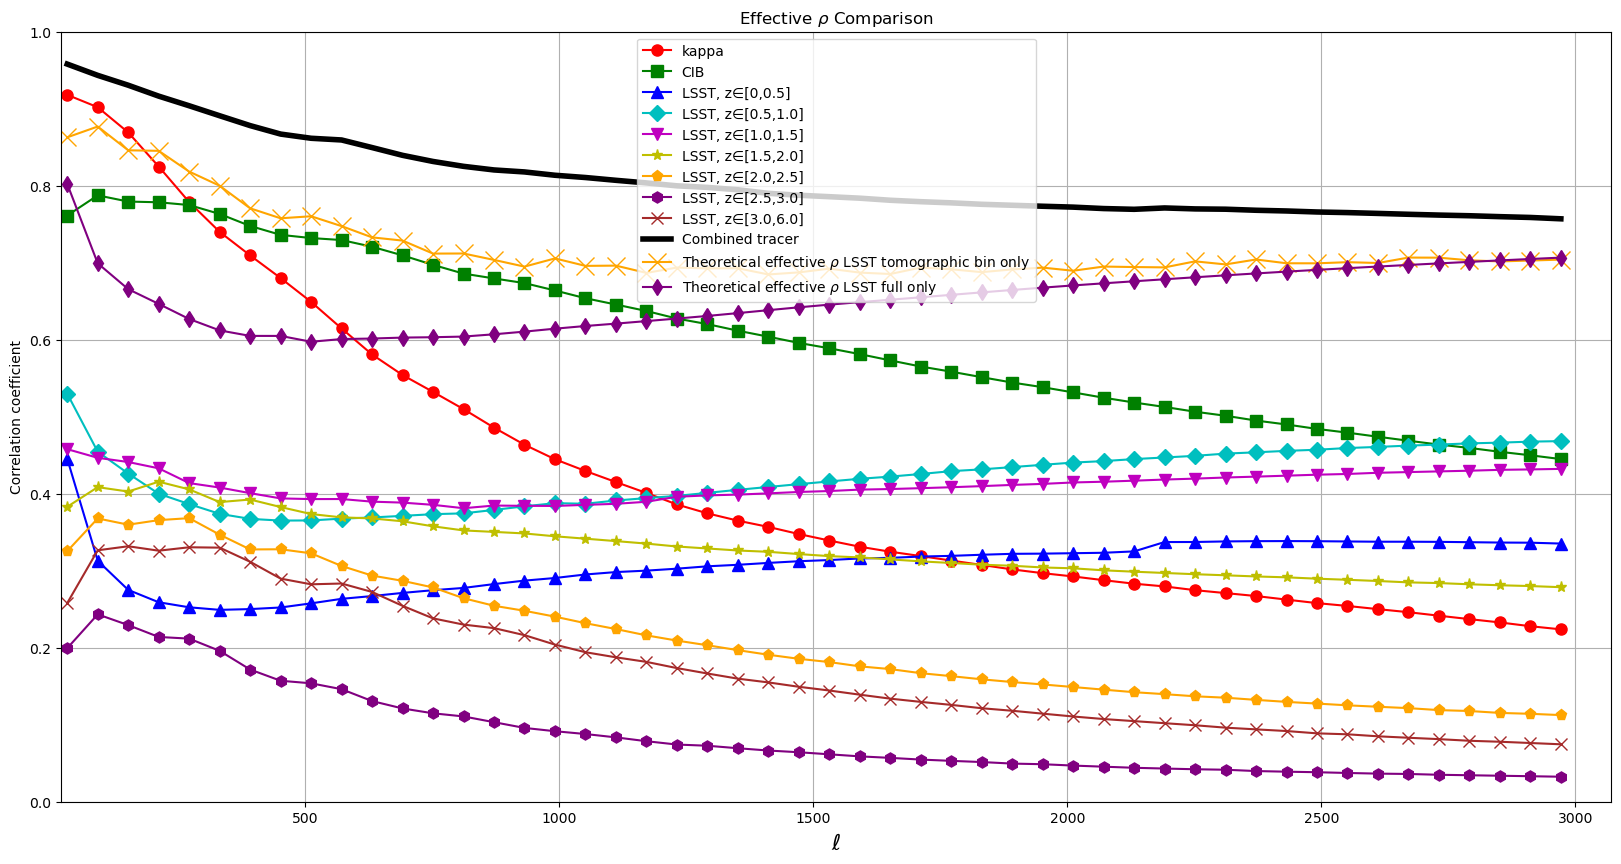

In [4]:
plt.figure(figsize=(20,10))

# Define some colors and markers
markers = ['o', 's', '^', 'D', 'v', '*', 'p', 'h', 'x']
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'purple', 'brown']
tracers = ['kappa', 'CIB', 'LSST1', 'LSST2', 'LSST3','LSST4','LSST5','LSST6','LSST7']

surveys0 = [
    'LSST, z∈[0,0.5]', 
    'LSST, z∈[0.5,1.0]', 
    'LSST, z∈[1.0,1.5]', 
    'LSST, z∈[1.5,2.0]', 
    'LSST, z∈[2.0,2.5]', 
    'LSST, z∈[2.5,3.0]', 
    'LSST, z∈[3.0,6.0]'
]


# Plot the data with specified colors and markers
for i, (key, color, marker) in enumerate(zip(tracers, colors, markers)):
    if i >= 2:
        plt.plot(lbin, rhos[i], label=surveys0[i-2], color=color, marker=marker, linestyle='-', markersize=8)
    else:
        plt.plot(lbin, rhos[i], label=f'{tracers[i]}', color=color, marker=marker, linestyle='-', markersize=8)

# Plot with specific color, marker, and linestyle

plt.plot(lbin, rhos_comb[0], color='k', linestyle='-',linewidth=4, label='Combined tracer')
plt.plot(lbin, rho_eff_LSST_tomo_binned, color='orange', marker='x', linestyle='-', markersize=13, label=r'Theoretical effective $\rho$ LSST tomographic bin only')
plt.plot(lbin, rho_LSST_full_binned, color='purple', marker='d', linestyle='-', markersize=8, label=r'Theoretical effective $\rho$ LSST full only')

# Add legend, axis limits, and show plot
plt.legend()
plt.xlim(20, 3071)
plt.ylim(0, 1.0)
plt.xlabel('$\ell$',fontsize=16)
plt.ylabel('Correlation coefficient')
plt.title(r'Effective $\rho$ Comparison')
plt.grid(True)
plt.show()

In [2]:
def plot_mean_with_error_bars_from_directory(directory_path, nmax):
    """
    一个bin中的nbl个点为一个样本,求得均值。
    k次模拟对应的该区间k个样本,求得k个均值。这k个均值的统计方差为sigma^2/nbl (sigma为分布标准差)
    (对一组数直接求方差,得到的是分布方差(方差的定义),相当于1个数当成1个样本得一个均值)
    这样可以考虑到在不同区间内数据的变化情况。
    """
    # 用于存储有效多极项和功率谱数组的列表
    ell_eff_list = []
    cl_binned_list = []

    # 获取目录中的所有文件名
    file_names = os.listdir(directory_path)
    NUM = 0 
    data = np.loadtxt(os.path.join(directory_path, file_names[0]))
    # 读取每个文件的数组数据并存储在列表中
    for file_name in file_names:
        file_path = os.path.join(directory_path, file_name)
        # 使用 get_binned 函数得到有效多极项和分 bin 后的功率谱数组
        cl_binned = np.loadtxt(file_path)
        #ell_eff = [ 26.5,  76.5, 126.5, 176.5, 226.5, 276.5, 326.5, 376.5, 426.5,
       #476.5, 526.5, 576.5, 626.5, 676.5, 726.5, 776.5, 826.5, 876.5,
       #926.5]
        # 存储到列表中
        #ell_eff_list.append(ell_eff)
        #cl_binned_list.append(cl_binned)
        cl_binned_list.append(cl_binned)
        NUM += 1
        if NUM == nmax:
            break

    # 计算平均值和标准差
    #mean_ell_eff = np.mean(ell_eff_list, axis=0)
    mean_cl_binned = np.mean(cl_binned_list, axis=0)
    std_dev_cl_binned = np.std(cl_binned_list, axis=0)

    # 绘制统计平均值和误差棒
    #plt.errorbar(mean_ell_eff, mean_cl_binned, yerr=std_dev_cl_binned, fmt='.', label='Mean with Error Bars')
    #plt.xlabel('Effective Multipole Moments')
    #plt.ylabel('Binned Power Spectrum')
    #plt.title('Mean and Error Bars of Binned Power Spectrum')
    #plt.legend()
    #plt.semilogy()
    #plt.ylim(1e-3,3e-1)
    #plt.show()

    return mean_cl_binned, std_dev_cl_binned

In [30]:
rhos,_ = plot_mean_with_error_bars_from_directory('/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/LSS_tracer/rhos', 200)

In [4]:
nside = 2048
lmax = 3071

file_indices = 134

rec_qlm_filename = f"/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/com_rec/rec_qlm_{file_indices}.fits"
P_filename = f"/sharefs/alicpt/users/chenwz/reconstruction_2048_simons/test/ALILENS/sims/cmbs/map_P_2048_{file_indices:04d}.fits"

nlpp = np.loadtxt('/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/nlpp_com.dat')[1]

CIB_filename = f"/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/LSS_tracer/CIB/CIB_{file_indices}.fits"
Euclid_filename = f"/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/LSS_tracer/Euclid/Euclid_{file_indices}.fits"
LSST_filename = f"/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/LSS_tracer/LSST/LSST_{file_indices}.fits"
WFIRST_filename = f"/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/LSS_tracer/WFIRST/WFIRST_{file_indices}.fits"
SKA_filename = f"/sharefs/alicpt/users/chenwz/reconstruction_multi_process2/process_added/LSS_tracer/SKA/SKA_{file_indices}.fits"


pmap = hp.read_map(f"{P_filename}",field=(0),)
plm = hp.map2alm(pmap, lmax)

plm_rec = hp.read_alm(f"{rec_qlm_filename}")

ls = np.arange(lmax+1)
q2k = lambda l: l*(l + 1) / 2
klm = hp.almxfl(plm, q2k(ls))
klm_rec = hp.almxfl(plm_rec, q2k(ls))

kmap = hp.alm2map(klm,nside)
kmap_rec = hp.alm2map(klm_rec,nside)
CIB_map = hp.alm2map(hp.read_alm(f"{CIB_filename}"),nside)
Euclid_map = hp.alm2map(hp.read_alm(f"{Euclid_filename}"),nside)
LSST_map = hp.alm2map(hp.read_alm(f"{LSST_filename}"),nside)
WFIRST_map = hp.alm2map(hp.read_alm(f"{WFIRST_filename}"),nside)
SKA_map = hp.alm2map(hp.read_alm(f"{SKA_filename}"),nside)

maps = [kmap_rec,CIB_map,Euclid_map,LSST_map,WFIRST_map,SKA_map]

#clkk = hp.anafast(kmap)

#rhos = []
#for i,map in enumerate(maps):
#    rhos.append(hp.anafast(kmap,map)/np.sqrt(clkk * hp.anafast(map)))


In [5]:
q2k = lambda l: l*(l + 1) / 2 # potential -> convergence
q2d = lambda l: (l*(l + 1)) ** 0.5 # potential -> deflection
cut = np.where((np.arange(lmax + 1) > 20) * (np.arange(lmax + 1) < 2000), 1, 0) # band limit

def view_map(m, title, min=None, max=None, cmap='YlGnBu_r'):
     """ View map.
     """
     # TODO beautify this plot
     rot = [180, 60, 0]


     m = hp.read_map(m, verbose=False) if isinstance(m, str) else m
     m[ m==0. ] = np.nan # in case the input map is an apodization mask

     if min==None: min = m[ ~np.isnan(m) ].min()
     if max==None: max = m[ ~np.isnan(m) ].max()
    
     hp.orthview(m, title=title, min=min, max=max, rot=rot, half_sky=True, cmap=cmap)

In [7]:
import utils
def k2d_map(map):
    alm = hp.map2alm(map)
    ls = np.arange(lmax+1)
    dlm = hp.almxfl(alm, cut * cli(q2k(np.arange(lmax + 1)))
                                     * q2d(np.arange(lmax + 1)))
                                     
    return hp.alm2map(dlm,nside)

In [6]:
mask = hp.read_map('/sharefs/alicpt/users/chenwz/reconstruction/mask/masks/AliCPT_20uKcut150_C_2048.fits')

In [9]:
dmap = k2d_map(kmap)* mask
dmap_obs = k2d_map(kmap_rec) * mask
cib = k2d_map(CIB_map) * mask
euclid = k2d_map(Euclid_map) * mask
lsst = k2d_map(LSST_map) * mask
wfirst = k2d_map(WFIRST_map) * mask
ska = k2d_map(SKA_map) * mask

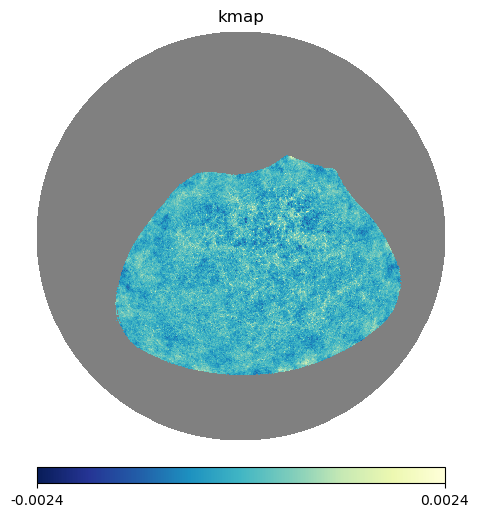

In [11]:
view_map(dmap-dmap_obs, 'kmap', min=-0.0024, max=0.0024, cmap='YlGnBu_r')

(0.0, 1.0)

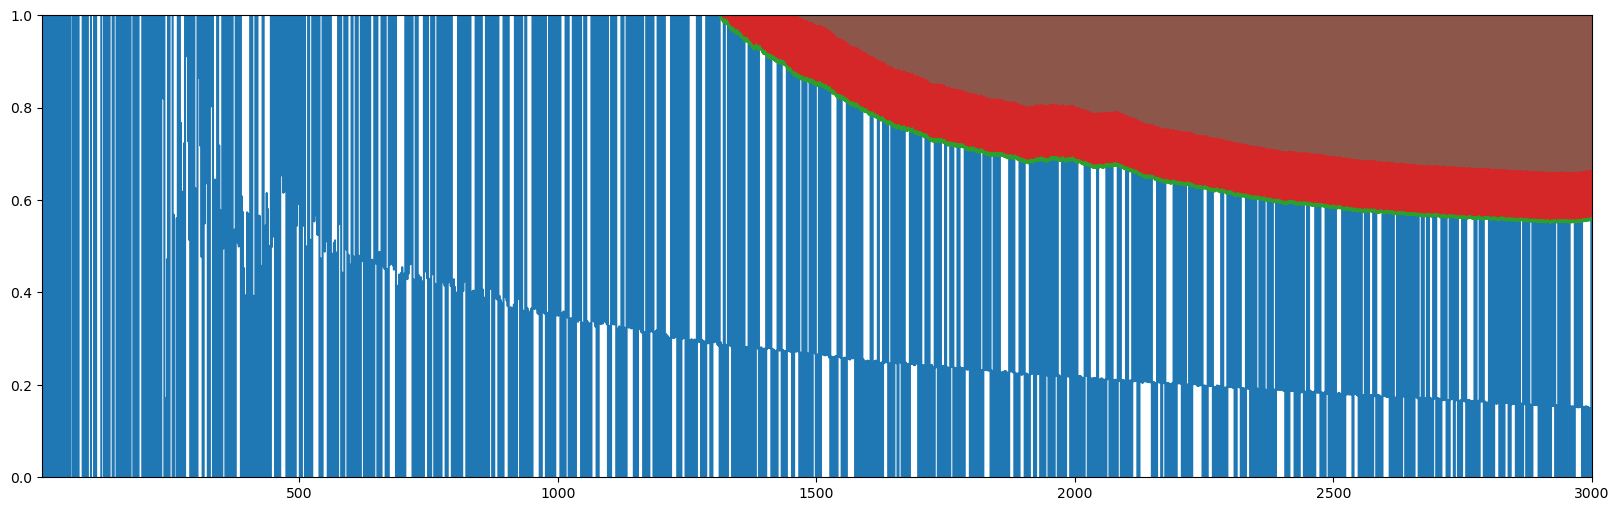

In [31]:
plt.figure(figsize=(20,6))
for i in range(len(rhos)):
    plt.plot(rhos[i], label='bin'+str(i))

plt.xlim(2,3000)
plt.ylim(0,1)